In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import nibabel as nib
import tqdm
from scipy import ndimage
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(1)

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

<h2> Tratamiento de los datos </h2>

<h3>Carga de los datos y de las rutas de las imagenes</h3>

En primer lugar elaboraremos un dataframe elaborado con Pandas en el que incluiremos las rutas de las imagenes, su identificación, la clase de cancer, su edad, su tipo de operación si es que ha realizado alguna y su supervivencia.
Tambien serán eliminados los campos que no sean importantes como las identificaciones de otros años.


In [ ]:
directory_path = 'G:\Dataset'
os.chdir(directory_path)

survival_path = os.path.join(directory_path, 'survival_info.csv')
survival_dataframe = pd.read_csv(survival_path, header=0, index_col='Brats20ID')
survival_dataframe.index.names = ['ID']

grade_dataframe = os.path.join(directory_path, 'name_mapping.csv')
grade_dataframe = pd.read_csv(grade_dataframe, header=0, index_col='BraTS_2020_subject_ID')
grade_dataframe.index.names = ['ID']

In [ ]:
dataframe = grade_dataframe.join(survival_dataframe)
dataframe.drop(columns=['BraTS_2017_subject_ID', 'BraTS_2018_subject_ID', 'TCGA_TCIA_subject_ID', 'BraTS_2019_subject_ID'], inplace=True)
dataframe.rename(columns={'Grade':'grade', 'Age':'age','Survival_days':'survival_days','Extent_of_Resection':'extent_of_resection'}, inplace=True)
dataframe.describe(include = 'all')

In [ ]:
def load_image_path(dataframe, directory_path):
    '''
    '''
    images=['_t1.nii', '_t1ce.nii', '_t2.nii', '_flair.nii']
    for ID in dataframe.index:
        dataframe.at[ID, 't1'] = os.path.join(directory_path, ID, ID+images[0])
        dataframe.at[ID, 't1ce'] = os.path.join(directory_path, ID, ID+images[1])
        dataframe.at[ID, 't2'] = os.path.join(directory_path, ID, ID+images[2])
        dataframe.at[ID, 'flair'] = os.path.join(directory_path, ID, ID+images[3])
    return dataframe

In [ ]:
dataframe = load_image_path(dataframe, directory_path)
dataframe.head()

<h3>Preprocesado de los datos</h3>

In [ ]:
#Analizando los datos podemos observar que todos los pacientes con un grado de tumor bajo no tienen datos de supervivencia ni de
#extracción del tumor, ni edad. Esto es en gran medida porque estos pacientes tienen un pronostico bastante favorable [1] y la mayoria no necesita cirugia.
#Por eso asumiremos que ninguno de ellos se realizo cirugía, su edad será fijada de forma aleatoria entre el minimo y el maximo de las edades y el tiempo de supervivencia sera aleatorio entre 
#https://www.analesdepediatria.org/es-gliomas-bajo-grado-revision-10-articulo-S1695403314000873#:~:text=La%20supervivencia%20global%20fue%20del%2088%2C3%25%2C%20con%20una,fue%20del%2083%2C7%25.
#https://ascopubs.org/doi/full/10.1200/JOP.2016.018622#:~:text=A%20larger%20study%20of%20216,of%20resection%20was%20%3C%2090%25.

#Segun el estudio [2] un 76% de las personas con una extirpación de menos del 90% del tumor sobrevivieron más de 5 años. Por lo que
#como asumimos que estas personas no se realizaron cirugía ya que no tenemos datos, calcularemos el tiempo de supervivencia como un número
#aleatorio entre 4 y 7 teniendo un 24% de ser entre 4-5 y un 76% de ser entre 5-7
#En cuanto a la edad esta será calcula aleatoriamente en el rango de la media del resto de las edades con la desviacion tipica [media-dt, media+dt] 
dataframe.loc[(dataframe['grade'] != 'HGG') & (pd.isna(dataframe['age']) == True)].head(5)

In [ ]:
def generate_survival(dataframe):
    '''
    '''
    a=4
    b=5
    c=7
    probability_low = 24
    indexes = dataframe.loc[(pd.isna(dataframe['age']) == True)].index
    survival_fill = pd.DataFrame([0 for i in range(0, len(indexes))], columns=['fill'], index=indexes)
    for i in indexes.values:
        low = np.random.randint((a*365), high=(b*365)+1)
        high = np.random.randint((b*365), high=(c*365)+1)
        probability = np.random.randint(1, high=101)
        
        if probability <= probability_low:
            survival_fill.loc[i, 'fill'] = low
        else:
            survival_fill.loc[i, 'fill'] = high
            
    return survival_fill['fill']

def generate_age(dataframe):
    '''
    '''
    indexes = dataframe.loc[(pd.isna(dataframe['age']) == True)].index
    age_fill = pd.DataFrame([0 for i in range(0, len(indexes))], columns=['fill'], index=indexes)
    
    ages = dataframe.loc[pd.isna(dataframe['age']) == False]
    age_mean = np.round(ages.mean(), 3)
    age_std = np.round(ages.std(), 3)
    minimo = age_mean-age_std
    maximo = age_mean+age_std
    
    for i in indexes.values:
        random = np.round(np.random.uniform(minimo, maximo), 3)
        age_fill.loc[i, 'fill'] = random
        
    return age_fill['fill']

def normalize_age(dataframe):
    '''
    '''
    max_value = dataframe['age'].max()
    min_value = dataframe['age'].min()
    dataframe['age'] = (dataframe['age'] - min_value) / (max_value - min_value)
    return dataframe

In [ ]:
dataframe['survival_days'].fillna(generate_survival(dataframe), inplace=True)
dataframe['age'].fillna(generate_age(dataframe), inplace=True)
#dataframe = normalize_age(dataframe)

grade_encoding = {'LGG':0, 'HGG':1}
dataframe['grade'] = dataframe['grade'].replace(grade_encoding)

dataframe.drop(dataframe.loc[dataframe['survival_days'] == 'ALIVE (361 days later)'].index, axis=0, inplace=True)
dataframe = dataframe.astype({"grade": int, 'survival_days':int})

survival_encoding = {'Short survivor':0, 'Mid survivor':1, 'Long survivor':2}
for i in dataframe.index:
    if dataframe['survival_days'].loc[i] < 365:
        dataframe.loc[[i],['survival_days']] = survival_encoding['Short survivor']
    elif dataframe['survival_days'].loc[i] < 1825:
        dataframe.loc[[i],['survival_days']] = survival_encoding['Mid survivor']
    else:
        dataframe.loc[[i],['survival_days']] = survival_encoding['Long survivor']
        
dataframe['extent_of_resection'].fillna('NONE', inplace=True)
dataframe = pd.get_dummies(dataframe, columns=['extent_of_resection'], prefix='resection_')


In [ ]:
dataframe.head()

In [ ]:
diff = dataframe.loc[dataframe['grade'] == 1].count()[0] - dataframe.loc[dataframe['grade'] == 0].count()[0]

In [ ]:
for i in range(diff):
    dataframe.drop(dataframe.loc[dataframe['grade'] == 1].index[-1], inplace=True)

<h3>Carga y preprocesado de las imagenes</h3>

In [ ]:
def read_scan(filepath):
    """Read and load volume"""
    # Read file
    img = nib.load(filepath)
    # Rotate the image to a fixed axes
    img = nib.as_closest_canonical(img)
    # Get raw data
    img = img.get_fdata()
    return img

def normalize(img):
    """Normalize the volume"""
    minimun = np.amin(img)
    maximun = np.amax(img)
    img = (img - minimun) / (maximun - minimun)
    img = img.astype("float32")
    return img[:,:,-90::30]

def resize_volume(img):
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / self.depth
    width = current_width / self.width
    height = current_height / self.height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img        

def preproces_images(dataframe):
    """
    Used to perform some minor preprocessing on the image before inputting into the network.
    """
    print("---preprocesando imágenes---")
    dataframe["t1p"] = None
    dataframe["t1cep"] = None
    dataframe["t2p"] = None
    dataframe["flairp"] = None

    indexes = dataframe.index
    for num, row in enumerate(dataframe.itertuples()):
        img = read_scan(row.t1)
        img = normalize(img)
        if(img.shape[2] != 3):
            print(img.shape)
        path = row.t1.rsplit('.', 1)[0]+'.npy'
        np.save(path, img)
        dataframe.at[indexes[num], 't1p'] = path

        img = read_scan(row.t1ce)
        img = normalize(img)
        if(img.shape[2] != 3):
            print(num)
        path = row.t1ce.rsplit('.', 1)[0]+'.npy'
        np.save(path, img)
        dataframe.at[indexes[num], 't1cep'] = path

        img = read_scan(row.t2)
        img = normalize(img)
        if(img.shape[2] != 3):
            print(num)
        path = row.t2.rsplit('.', 1)[0]+'.npy'
        np.save(path, img)
        dataframe.at[indexes[num], 't2p'] = path

        img = read_scan(row.flair)
        img = normalize(img)
        if(img.shape[2] != 3):
            print(num)
        path = row.flair.rsplit('.', 1)[0]+'.npy'
        np.save(path, img)
        dataframe.at[indexes[num], 'flairp'] = path
    print("---preprocesado finalizado---")
    return dataframe

def get_paths(dataframe):
    """
    Used to perform some minor preprocessing on the image before inputting into the network.
    """
    print("---guardando rutas---")
    dataframe["t1p"] = None
    dataframe["t1cep"] = None
    dataframe["t2p"] = None
    dataframe["flairp"] = None
    indexes = dataframe.index
    
    for num, row in enumerate(dataframe.itertuples()):
        path = row.t1.rsplit('.', 1)[0]+'.npy'
        dataframe.at[indexes[num], 't1p'] = path

        path = row.t1ce.rsplit('.', 1)[0]+'.npy'
        dataframe.at[indexes[num], 't1cep'] = path

        path = row.t2.rsplit('.', 1)[0]+'.npy'
        dataframe.at[indexes[num], 't2p'] = path

        path = row.flair.rsplit('.', 1)[0]+'.npy'
        dataframe.at[indexes[num], 'flairp'] = path
    print("---rutas guardadas---")
    return dataframe

In [ ]:
#dataframe = preproces_images(dataframe)
dataframe = get_paths(dataframe)

In [ ]:
# def generate_data(indexes, dataframe, output):
#     """
#     Used to generate a batch with images when training/testing/validating our Keras model.
#     """
#     dataframe_2 = dataframe.iloc[indexes]
#     # arrays to store our batched data
#     X, y = [], []
#     aux = np.zeros(shape=(1,4)).astype('float32')
#     for row in dataframe_2.itertuples():

#         t1_path = row.t1p
#         t1ce_path = row.t1cep
#         t2_path = row.t2p
#         flair_path = row.flairp

#         for i in range(4):
#             if(i == 0):
#                 img = np.load(t1_path)
#             elif(i == 1):
#                 img = np.load(t1ce_path)
#             elif(i == 2):
#                 img = np.load(t2_path)
#             elif(i == 3):
#                 img = np.load(flair_path)

#             if(output == 'grade'):
#                 aux[0, 0] = row.age
#                 aux[0, 1] = row.resection__GTR
#                 aux[0, 2] = row.resection__NONE
#                 aux[0, 3] = row.resection__STR

#                 y.append(np.array(to_categorical(row.grade, 2)).astype('float32'))
#                 X.append([img, aux])
#             else:
#                 aux[0, 0] = row.age*100
#                 aux[0, 1] = row.resection__GTR*100
#                 aux[0, 2] = row.resection__NONE*100
#                 aux[0, 3] = row.resection__STR*100
#                 y.append(np.array(to_categorical(row.survival, 3)).astype('float32'))
#                 X.append([img, aux])

#     return np.array(X), np.array(y)

# X_grade_train, y_grade_train = generate_data(train_index, dataframe, 'grade')
# X_grade_valid, y_grade_valid = generate_data(valid_inex, dataframe, 'grade')
# X_grade_test, y_grade_test = generate_data(test_index, dataframe, 'grade')
# X_survival_train, y_survival_train = generate_data(train_index, dataframe, 'survival')
# X_survival_valid, y_survival_valid = generate_data(valid_inex, dataframe, 'survival')
# X_survival_test, y_survival_test = generate_data(test_index, dataframe, 'survival')

In [ ]:
class Data_generator():
    """
    Data generator
    """
    def __init__(self, dataframe, train_size, width, height, depth):
        self.dataframe = dataframe
        self.train_size = train_size
        self.slices = slices
        self.width = width
        self.height = height
        self.depth = depth
        
    def generate_split_indexes(self):
        '''
        '''
        np.random.seed(1)
        permutation = np.random.permutation(len(self.dataframe))
        index = int(len(self.dataframe) * self.train_size)
        train_index = permutation[:index]
        test_index = permutation[index:]
        
        index = int(index * self.train_size)
        train_index, valid_index = train_index[:index], train_index[index:]
        
        return train_index, valid_index, test_index
    
    
    def generate_data(self, indexes, is_training, output, batch_size=32):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        dataframe = self.dataframe.iloc[indexes]
        # arrays to store our batched data
        images, text, labels = [], [], []
        while True:
            for row in dataframe.itertuples():
                
                t1_path = row.t1p
                t1ce_path = row.t1cep
                t2_path = row.t2p
                flair_path = row.flairp
                for i in range(4):
                    if(i == 0):
                        img = np.load(t1_path)
                    elif(i == 1):
                        img = np.load(t1ce_path)
                    elif(i == 2):
                        img = np.load(t2_path)
                    elif(i == 3):
                        img = np.load(flair_path)
                    images.append(img)
                    
                    if(output == 'grade'):
                        labels.append(to_categorical(row.grade, 2))
                        text.append([row.age, row.resection__GTR, row.resection__NONE, row.resection__STR])
                    else:
                        labels.append(to_categorical(row.survival_days, 3))
                        text.append([row.age*10, row.resection__GTR*10, row.resection__NONE*10, row.resection__STR*10])
                    

                    # Lo que hace yield es crear un generador, es decir, cuando se ejecute este trozo de código no se ejecuta
                    # instantaneamente, sino que más adelante cuando internamente el programa llame a next se ejecutará el código
                    # hasta que se encuentre un yield y ahí parará. Con el siguiente next volvera a hacer una iteración y así.
                    if len(images) >= batch_size:
                        yield [np.float32(images), np.float32(text)], np.float32(labels)
                        images, text, labels = [], [], []
                    
            if not is_training:
                break

In [ ]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2,figsize=(16,4))
    
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Precisión del modelo')
    axs[0].set(xlabel='Epoch', ylabel='Precisión')
    axs[0].legend(['Entrenamiento', 'Validación'], loc='upper left')
    
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Perdida del modelo')
    axs[1].set(xlabel='Epoch', ylabel='Perdida')
    axs[1].legend(['Entrenamiento', 'Validación'], loc='upper left')
    
    plt.show()

In [ ]:
def plot_results(true, pred, encoding):
    pred = np.argmax(pred, axis=1)
    cr_survival = classification_report(true, pred, target_names=encoding.keys())
    print(cr_survival)

In [ ]:
def plot_confusion(true, pred, encoding):
    pred = np.argmax(pred, axis=1)
    cf_matrix = confusion_matrix(true, pred)
    ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')

    ax.set_title('Matriz de confusión\n\n');
    ax.set_xlabel('\nValores predichos')
    ax.set_ylabel('Valores reales ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(encoding.keys(),)
    ax.yaxis.set_ticklabels(encoding.keys(),)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [ ]:
train_size = 0.80
image_width = 240
image_height = 240
slices = 3

data_generator = Data_generator(dataframe, train_size, image_width, image_height, slices)
train_index, valid_index, test_index = data_generator.generate_split_indexes() 

## DenseNet121 batch-batch

In [ ]:
Dense(256, activation="relu")
BatchNormalization()
Dropout(0.5)
Dense(512, activation="relu")
Dense(3)
Activation("softmax")

In [45]:
def crear_rama_grado(modelo, input_text):
    """
    crea la rama que predice el grado del tumor
    """
    rama_grado = layers.Concatenate()([modelo, input_text])

    rama_grado = layers.Dense(256, activation="relu")(rama_grado)
    rama_grado = layers.BatchNormalization()(rama_grado)
    rama_grado = layers.Dropout(0.5)(rama_grado)
    rama_grado = layers.Dense(512, activation="relu")(rama_grado)
    rama_grado = layers.Dense(2)(rama_grado)
    rama_grado = layers.Activation("softmax", name="grade")(rama_grado)

    return rama_grado

def crear_rama_supervivencia(modelo, input_text):
    """
    crea la rama que predice la supervivencia del paciente
    """
    rama_supervivencia = layers.Concatenate()([modelo, input_text])

    rama_supervivencia = layers.Dense(256, activation="relu")(rama_supervivencia)
    rama_supervivencia = layers.BatchNormalization()(rama_supervivencia)
    rama_supervivencia = layers.Dropout(0.5)(rama_supervivencia)
    rama_supervivencia = layers.Dense(512, activation="relu")(rama_supervivencia)
    rama_supervivencia = layers.Dense(3)(rama_supervivencia)
    rama_supervivencia = layers.Activation("softmax", name="survival")(rama_supervivencia)

    return rama_supervivencia

In [46]:
from tensorflow.keras.applications.densenet import DenseNet121
input_text = layers.Input(shape=(4,))

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_grado = crear_rama_grado(base, input_text)

rama_supervivencia = crear_rama_supervivencia(base, input_text)

# Model to be trained
grade_model = Model(inputs=[base_model.input, input_text], outputs=rama_grado, name="grade_model")
survival_model = Model(inputs=[base_model.input, input_text], outputs=rama_supervivencia, name="survival_model")
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = True

grade_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="binary_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

survival_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="categorical_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

In [47]:
epochs = 10
batch_size = 16
valid_batch_size = 16

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, min_delta=0.01)
Reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    min_delta=0.01,
)

callbacks = [earylyStopping, Reducer]
train_gen = data_generator.generate_data(train_index, is_training=True, output='survival', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='survival', batch_size=valid_batch_size)

print("\n-----------------------------------------------SUPERVIVENCIA-----------------------------------------------")
survival_history = survival_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------SUPERVIVENCIA-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 22s 382ms/step - loss: 1.1579 - accuracy: 0.4323 - recall_9: 0.2422 - val_loss: 5.1207 - val_accuracy: 0.1667 - val_recall_9: 0.1667
Epoch 2/10
24/24 [==============================] - 6s 266ms/step - loss: 0.9162 - accuracy: 0.5651 - recall_9: 0.4089 - val_loss: 3.0668 - val_accuracy: 0.3750 - val_recall_9: 0.3750
Epoch 3/10
24/24 [==============================] - 6s 270ms/step - loss: 0.7990 - accuracy: 0.6823 - recall_9: 0.5651 - val_loss: 2.1179 - val_accuracy: 0.3021 - val_recall_9: 0.2917
Epoch 4/10
24/24 [==============================] - 6s 271ms/step - loss: 0.6753 - accuracy: 0.7083 - recall_9: 0.6094 - val_loss: 1.7072 - val_accuracy: 0.4271 - val_recall_9: 0.4271
Epoch 5/10
24/24 [==============================] - 6s 268ms/step - loss: 0.6219 - accuracy: 0.7682 - recall_9: 0.6589 - val_loss: 1.4473 - val_accuracy: 

In [48]:
train_gen = data_generator.generate_data(train_index, is_training=True, output='grade', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='grade', batch_size=valid_batch_size)

print("\n-----------------------------------------------GRADO-----------------------------------------------")
grade_history = grade_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------GRADO-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 22s 350ms/step - loss: 0.4251 - accuracy: 0.8255 - recall_8: 0.8255 - val_loss: 0.5125 - val_accuracy: 0.8125 - val_recall_8: 0.8125
Epoch 2/10
24/24 [==============================] - 6s 250ms/step - loss: 0.2619 - accuracy: 0.9167 - recall_8: 0.9167 - val_loss: 0.6072 - val_accuracy: 0.6146 - val_recall_8: 0.6146
Epoch 3/10
24/24 [==============================] - 6s 258ms/step - loss: 0.2397 - accuracy: 0.9089 - recall_8: 0.9089 - val_loss: 0.8094 - val_accuracy: 0.5938 - val_recall_8: 0.5938
Epoch 4/10
24/24 [==============================] - 6s 257ms/step - loss: 0.2221 - accuracy: 0.9349 - recall_8: 0.9349 - val_loss: 0.4126 - val_accuracy: 0.8333 - val_recall_8: 0.8333
Epoch 5/10
24/24 [==============================] - 6s 257ms/step - loss: 0.1881 - accuracy: 0.9323 - recall_8: 0.9323 - val_loss: 0.5996 - val_accuracy: 0.7188 -

In [49]:
#grade_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-grade.h5")
#survival_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-survival.h5")

# 5. Evaluación

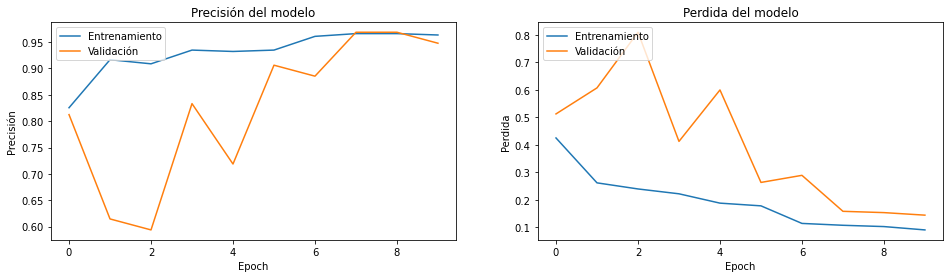

In [50]:
plot_history(grade_history)

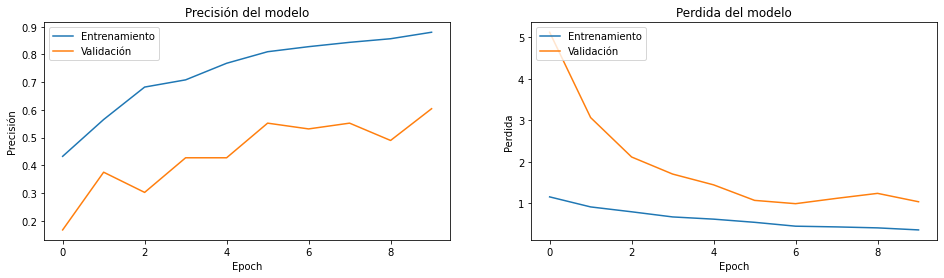

In [51]:
plot_history(survival_history)

In [52]:
grade_true = []
test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='grade', batch_size=test_batch_size )
grade_pred = grade_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)


index = dataframe.iloc[test_index]['grade']
for i in index:
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)

In [53]:

test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='survival', batch_size=test_batch_size )
survival_pred = survival_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)



survival_true = []
index = dataframe.iloc[test_index]['survival_days']
for i in index:
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)

In [54]:
plot_results(grade_true, grade_pred, grade_encoding)

              precision    recall  f1-score   support

         LGG       0.93      0.96      0.95        56
         HGG       0.97      0.94      0.96        68

    accuracy                           0.95       124
   macro avg       0.95      0.95      0.95       124
weighted avg       0.95      0.95      0.95       124



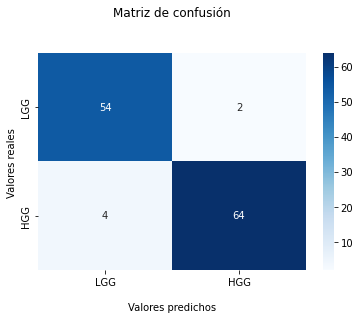

In [55]:
plot_confusion(grade_true, grade_pred, grade_encoding)

In [56]:
plot_results(survival_true, survival_pred, survival_encoding)

                precision    recall  f1-score   support

Short survivor       0.58      0.72      0.64        36
  Mid survivor       0.60      0.16      0.25        56
 Long survivor       0.50      1.00      0.67        32

      accuracy                           0.54       124
     macro avg       0.56      0.63      0.52       124
  weighted avg       0.57      0.54      0.47       124



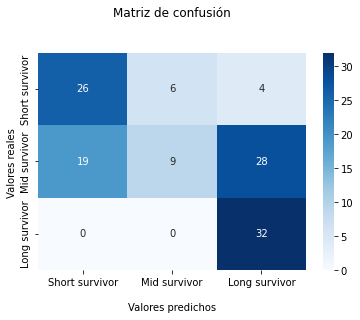

In [57]:
plot_confusion(survival_true, survival_pred, survival_encoding)

In [58]:
from tensorflow.keras.applications.densenet import DenseNet201
input_text = layers.Input(shape=(4,))

base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_grado = crear_rama_grado(base, input_text)

rama_supervivencia = crear_rama_supervivencia(base, input_text)

# Model to be trained
grade_model = Model(inputs=[base_model.input, input_text], outputs=rama_grado, name="grade_model")
survival_model = Model(inputs=[base_model.input, input_text], outputs=rama_supervivencia, name="survival_model")
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = True

grade_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="binary_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

survival_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="categorical_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

In [59]:
batch_size = 16
valid_batch_size = 16

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, min_delta=0.01)
Reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    min_delta=0.01,
)

callbacks = [earylyStopping, Reducer]
train_gen = data_generator.generate_data(train_index, is_training=True, output='survival', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='survival', batch_size=valid_batch_size)

print("\n-----------------------------------------------SUPERVIVENCIA-----------------------------------------------")
survival_history = survival_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------SUPERVIVENCIA-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 36s 567ms/step - loss: 1.1814 - accuracy: 0.4375 - recall_11: 0.2734 - val_loss: 2.5153 - val_accuracy: 0.4167 - val_recall_11: 0.4167
Epoch 2/10
24/24 [==============================] - 10s 415ms/step - loss: 0.9031 - accuracy: 0.5938 - recall_11: 0.4557 - val_loss: 1.4722 - val_accuracy: 0.4271 - val_recall_11: 0.4167
Epoch 3/10
24/24 [==============================] - 10s 407ms/step - loss: 0.7157 - accuracy: 0.7135 - recall_11: 0.5755 - val_loss: 1.0933 - val_accuracy: 0.6354 - val_recall_11: 0.5208
Epoch 4/10
24/24 [==============================] - 10s 419ms/step - loss: 0.6161 - accuracy: 0.7604 - recall_11: 0.6745 - val_loss: 1.0938 - val_accuracy: 0.5729 - val_recall_11: 0.5208
Epoch 5/10
24/24 [==============================] - 10s 405ms/step - loss: 0.4940 - accuracy: 0.8490 - recall_11: 0.7578 - val_loss: 1.3820 - v

In [60]:
train_gen = data_generator.generate_data(train_index, is_training=True, output='grade', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='grade', batch_size=valid_batch_size)

print("\n-----------------------------------------------GRADO-----------------------------------------------")
grade_history = grade_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------GRADO-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 37s 635ms/step - loss: 0.4739 - accuracy: 0.8151 - recall_10: 0.8151 - val_loss: 0.5403 - val_accuracy: 0.7292 - val_recall_10: 0.7292
Epoch 2/10
24/24 [==============================] - 10s 405ms/step - loss: 0.3187 - accuracy: 0.8854 - recall_10: 0.8854 - val_loss: 0.4491 - val_accuracy: 0.8333 - val_recall_10: 0.8333
Epoch 3/10
24/24 [==============================] - 10s 407ms/step - loss: 0.2640 - accuracy: 0.9245 - recall_10: 0.9245 - val_loss: 0.4509 - val_accuracy: 0.7396 - val_recall_10: 0.7396
Epoch 4/10
24/24 [==============================] - 10s 416ms/step - loss: 0.2073 - accuracy: 0.9479 - recall_10: 0.9479 - val_loss: 0.3597 - val_accuracy: 0.8646 - val_recall_10: 0.8646
Epoch 5/10
24/24 [==============================] - 10s 401ms/step - loss: 0.1638 - accuracy: 0.9427 - recall_10: 0.9427 - val_loss: 0.4205 - val_accur

In [61]:
#grade_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-grade.h5")
#survival_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-survival.h5")

# 5. Evaluación

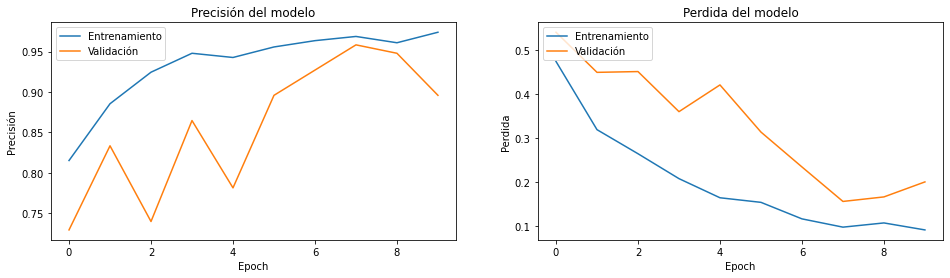

In [62]:
plot_history(grade_history)

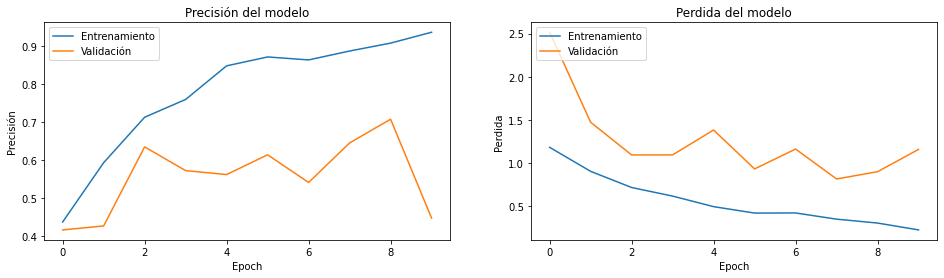

In [63]:
plot_history(survival_history)

In [64]:
grade_true = []
test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='grade', batch_size=test_batch_size )
grade_pred = grade_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)


index = dataframe.iloc[test_index]['grade']
for i in index:
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)

In [65]:

test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='survival', batch_size=test_batch_size )
survival_pred = survival_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)



survival_true = []
index = dataframe.iloc[test_index]['survival_days']
for i in index:
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)

In [66]:
plot_results(grade_true, grade_pred, grade_encoding)

              precision    recall  f1-score   support

         LGG       0.86      0.96      0.91        56
         HGG       0.97      0.87      0.91        68

    accuracy                           0.91       124
   macro avg       0.91      0.92      0.91       124
weighted avg       0.92      0.91      0.91       124



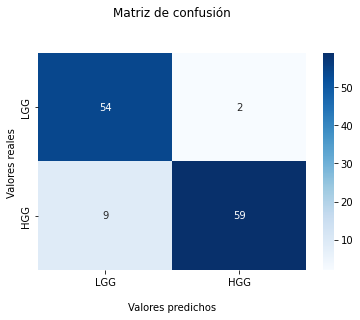

In [67]:
plot_confusion(grade_true, grade_pred, grade_encoding)

In [68]:
plot_results(survival_true, survival_pred, survival_encoding)

                precision    recall  f1-score   support

Short survivor       0.62      0.36      0.46        36
  Mid survivor       0.56      0.36      0.43        56
 Long survivor       0.48      1.00      0.65        32

      accuracy                           0.52       124
     macro avg       0.55      0.57      0.51       124
  weighted avg       0.55      0.52      0.50       124



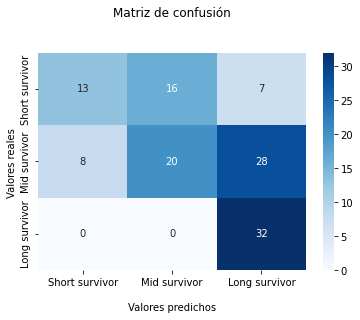

In [69]:
plot_confusion(survival_true, survival_pred, survival_encoding)

In [71]:
from tensorflow.keras.applications.resnet import ResNet50
input_text = layers.Input(shape=(4,))

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_grado = crear_rama_grado(base, input_text)

rama_supervivencia = crear_rama_supervivencia(base, input_text)

# Model to be trained
grade_model = Model(inputs=[base_model.input, input_text], outputs=rama_grado, name="grade_model")
survival_model = Model(inputs=[base_model.input, input_text], outputs=rama_supervivencia, name="survival_model")
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = True

grade_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="binary_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

survival_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="categorical_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

In [72]:

batch_size = 16
valid_batch_size = 16

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, min_delta=0.01)
Reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    min_delta=0.01,
)

callbacks = [earylyStopping, Reducer]
train_gen = data_generator.generate_data(train_index, is_training=True, output='survival', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='survival', batch_size=valid_batch_size)

print("\n-----------------------------------------------SUPERVIVENCIA-----------------------------------------------")
survival_history = survival_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------SUPERVIVENCIA-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 15s 308ms/step - loss: 1.1721 - accuracy: 0.4401 - recall_15: 0.2734 - val_loss: 5.2285 - val_accuracy: 0.4167 - val_recall_15: 0.4167
Epoch 2/10
24/24 [==============================] - 6s 252ms/step - loss: 0.9392 - accuracy: 0.5625 - recall_15: 0.4193 - val_loss: 4.3162 - val_accuracy: 0.4167 - val_recall_15: 0.4167
Epoch 3/10
24/24 [==============================] - 6s 254ms/step - loss: 0.7311 - accuracy: 0.7318 - recall_15: 0.6042 - val_loss: 2.9454 - val_accuracy: 0.4583 - val_recall_15: 0.4583
Epoch 4/10
24/24 [==============================] - 6s 247ms/step - loss: 0.6269 - accuracy: 0.7630 - recall_15: 0.6719 - val_loss: 2.6216 - val_accuracy: 0.4167 - val_recall_15: 0.4167
Epoch 5/10
24/24 [==============================] - 6s 248ms/step - loss: 0.5250 - accuracy: 0.8151 - recall_15: 0.7708 - val_loss: 2.4672 - val_a

In [73]:
train_gen = data_generator.generate_data(train_index, is_training=True, output='grade', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='grade', batch_size=valid_batch_size)

print("\n-----------------------------------------------GRADO-----------------------------------------------")
grade_history = grade_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------GRADO-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 14s 301ms/step - loss: 0.4546 - accuracy: 0.8151 - recall_14: 0.8151 - val_loss: 0.7034 - val_accuracy: 0.5000 - val_recall_14: 0.5000
Epoch 2/10
24/24 [==============================] - 6s 245ms/step - loss: 0.3409 - accuracy: 0.8828 - recall_14: 0.8828 - val_loss: 0.6951 - val_accuracy: 0.5000 - val_recall_14: 0.5000
Epoch 3/10
24/24 [==============================] - 6s 242ms/step - loss: 0.2694 - accuracy: 0.9349 - recall_14: 0.9349 - val_loss: 0.6772 - val_accuracy: 0.5833 - val_recall_14: 0.5833
Epoch 4/10
24/24 [==============================] - 6s 245ms/step - loss: 0.1947 - accuracy: 0.9375 - recall_14: 0.9375 - val_loss: 0.6805 - val_accuracy: 0.6250 - val_recall_14: 0.6250
Epoch 5/10
24/24 [==============================] - 6s 244ms/step - loss: 0.1458 - accuracy: 0.9531 - recall_14: 0.9531 - val_loss: 0.6725 - val_accuracy:

In [74]:
#grade_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-grade.h5")
#survival_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-survival.h5")

# 5. Evaluación

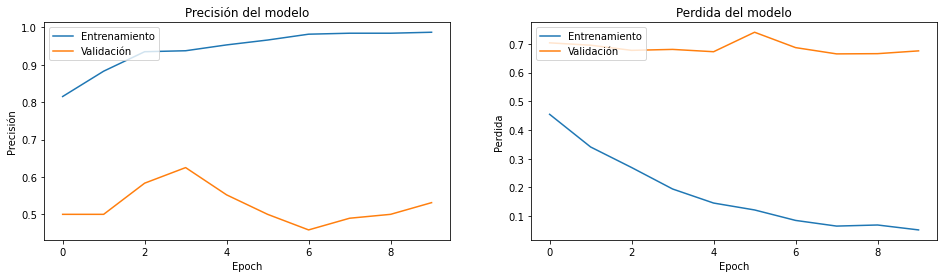

In [75]:
plot_history(grade_history)

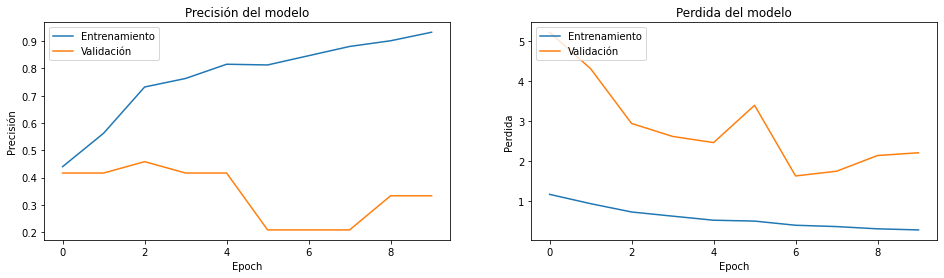

In [76]:
plot_history(survival_history)

In [77]:
grade_true = []
test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='grade', batch_size=test_batch_size )
grade_pred = grade_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)


index = dataframe.iloc[test_index]['grade']
for i in index:
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)

In [78]:

test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='survival', batch_size=test_batch_size )
survival_pred = survival_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)



survival_true = []
index = dataframe.iloc[test_index]['survival_days']
for i in index:
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)

In [79]:
plot_results(grade_true, grade_pred, grade_encoding)

              precision    recall  f1-score   support

         LGG       0.83      0.27      0.41        56
         HGG       0.61      0.96      0.75        68

    accuracy                           0.65       124
   macro avg       0.72      0.61      0.58       124
weighted avg       0.71      0.65      0.59       124



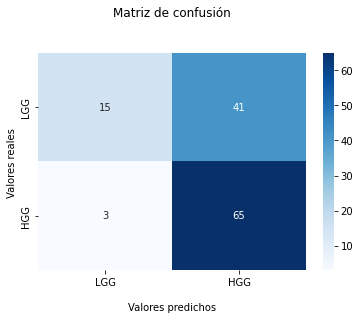

In [80]:
plot_confusion(grade_true, grade_pred, grade_encoding)

In [81]:
plot_results(survival_true, survival_pred, survival_encoding)

                precision    recall  f1-score   support

Short survivor       0.25      0.56      0.34        36
  Mid survivor       0.50      0.02      0.03        56
 Long survivor       0.10      0.12      0.11        32

      accuracy                           0.20       124
     macro avg       0.28      0.23      0.16       124
  weighted avg       0.32      0.20      0.14       124



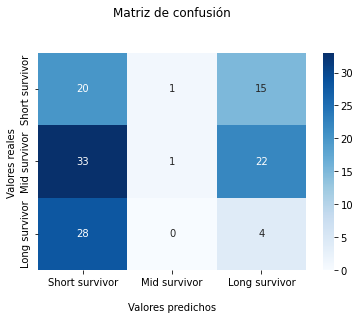

In [82]:
plot_confusion(survival_true, survival_pred, survival_encoding)

In [83]:
from tensorflow.keras.applications.resnet import ResNet101
input_text = layers.Input(shape=(4,))

base_model = ResNet101(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_grado = crear_rama_grado(base, input_text)

rama_supervivencia = crear_rama_supervivencia(base, input_text)

# Model to be trained
grade_model = Model(inputs=[base_model.input, input_text], outputs=rama_grado, name="grade_model")
survival_model = Model(inputs=[base_model.input, input_text], outputs=rama_supervivencia, name="survival_model")
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = True

grade_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="binary_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

survival_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="categorical_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

In [84]:

batch_size = 16
valid_batch_size = 16

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, min_delta=0.01)
Reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    min_delta=0.01,
)

callbacks = [earylyStopping, Reducer]
train_gen = data_generator.generate_data(train_index, is_training=True, output='survival', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='survival', batch_size=valid_batch_size)

print("\n-----------------------------------------------SUPERVIVENCIA-----------------------------------------------")
survival_history = survival_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------SUPERVIVENCIA-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 25s 514ms/step - loss: 1.1524 - accuracy: 0.4609 - recall_17: 0.2656 - val_loss: 4.1130 - val_accuracy: 0.4167 - val_recall_17: 0.4167
Epoch 2/10
24/24 [==============================] - 10s 415ms/step - loss: 0.9099 - accuracy: 0.5807 - recall_17: 0.4922 - val_loss: 3.1111 - val_accuracy: 0.4167 - val_recall_17: 0.4167
Epoch 3/10
24/24 [==============================] - 10s 412ms/step - loss: 0.8215 - accuracy: 0.6719 - recall_17: 0.5625 - val_loss: 2.4870 - val_accuracy: 0.4583 - val_recall_17: 0.4583
Epoch 4/10
24/24 [==============================] - 10s 409ms/step - loss: 0.6762 - accuracy: 0.7422 - recall_17: 0.6510 - val_loss: 2.1197 - val_accuracy: 0.4583 - val_recall_17: 0.4583
Epoch 5/10
24/24 [==============================] - 10s 408ms/step - loss: 0.5957 - accuracy: 0.7656 - recall_17: 0.6875 - val_loss: 1.8971 - v

In [85]:
train_gen = data_generator.generate_data(train_index, is_training=True, output='grade', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='grade', batch_size=valid_batch_size)

print("\n-----------------------------------------------GRADO-----------------------------------------------")
grade_history = grade_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------GRADO-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 26s 508ms/step - loss: 0.4730 - accuracy: 0.7995 - recall_16: 0.7995 - val_loss: 0.7781 - val_accuracy: 0.5000 - val_recall_16: 0.5000
Epoch 2/10
24/24 [==============================] - 10s 401ms/step - loss: 0.3576 - accuracy: 0.8698 - recall_16: 0.8698 - val_loss: 0.7502 - val_accuracy: 0.5000 - val_recall_16: 0.5000
Epoch 3/10
24/24 [==============================] - 10s 399ms/step - loss: 0.2807 - accuracy: 0.9036 - recall_16: 0.9036 - val_loss: 0.8059 - val_accuracy: 0.5417 - val_recall_16: 0.5417
Epoch 4/10
24/24 [==============================] - 9s 397ms/step - loss: 0.2209 - accuracy: 0.9349 - recall_16: 0.9349 - val_loss: 0.8996 - val_accuracy: 0.5000 - val_recall_16: 0.5000
Epoch 5/10
24/24 [==============================] - 10s 399ms/step - loss: 0.1845 - accuracy: 0.9427 - recall_16: 0.9427 - val_loss: 0.8095 - val_accura

In [86]:
#grade_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-grade.h5")
#survival_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-survival.h5")

# 5. Evaluación

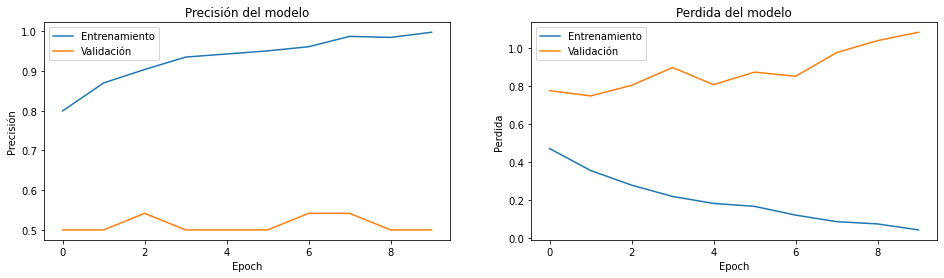

In [87]:
plot_history(grade_history)

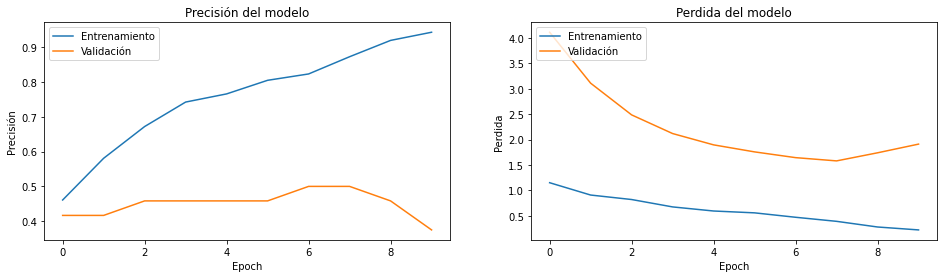

In [88]:
plot_history(survival_history)

In [89]:
grade_true = []
test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='grade', batch_size=test_batch_size )
grade_pred = grade_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)


index = dataframe.iloc[test_index]['grade']
for i in index:
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)

In [90]:

test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='survival', batch_size=test_batch_size )
survival_pred = survival_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)



survival_true = []
index = dataframe.iloc[test_index]['survival_days']
for i in index:
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)

In [91]:
plot_results(grade_true, grade_pred, grade_encoding)

              precision    recall  f1-score   support

         LGG       0.45      1.00      0.62        56
         HGG       0.00      0.00      0.00        68

    accuracy                           0.45       124
   macro avg       0.23      0.50      0.31       124
weighted avg       0.20      0.45      0.28       124



G:\Anaconda\envs\Santi2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\Anaconda\envs\Santi2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\Anaconda\envs\Santi2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


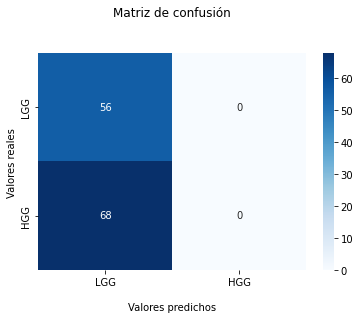

In [92]:
plot_confusion(grade_true, grade_pred, grade_encoding)

In [93]:
plot_results(survival_true, survival_pred, survival_encoding)

                precision    recall  f1-score   support

Short survivor       0.47      0.78      0.58        36
  Mid survivor       0.00      0.00      0.00        56
 Long survivor       0.50      1.00      0.67        32

      accuracy                           0.48       124
     macro avg       0.32      0.59      0.42       124
  weighted avg       0.26      0.48      0.34       124



G:\Anaconda\envs\Santi2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\Anaconda\envs\Santi2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\Anaconda\envs\Santi2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


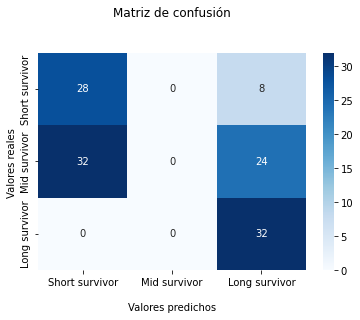

In [94]:
plot_confusion(survival_true, survival_pred, survival_encoding)

In [95]:
from tensorflow.keras.applications.vgg16 import VGG16
input_text = layers.Input(shape=(4,))

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_grado = crear_rama_grado(base, input_text)

rama_supervivencia = crear_rama_supervivencia(base, input_text)

# Model to be trained
grade_model = Model(inputs=[base_model.input, input_text], outputs=rama_grado, name="grade_model")
survival_model = Model(inputs=[base_model.input, input_text], outputs=rama_supervivencia, name="survival_model")
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = True

grade_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="binary_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

survival_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="categorical_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

In [96]:
batch_size = 16
valid_batch_size = 16

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, min_delta=0.01)
Reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    min_delta=0.01,
)

callbacks = [earylyStopping, Reducer]
train_gen = data_generator.generate_data(train_index, is_training=True, output='survival', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='survival', batch_size=valid_batch_size)

print("\n-----------------------------------------------SUPERVIVENCIA-----------------------------------------------")
survival_history = survival_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------SUPERVIVENCIA-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 21s 363ms/step - loss: 1.2109 - accuracy: 0.3776 - recall_19: 0.2318 - val_loss: 1.5831 - val_accuracy: 0.4062 - val_recall_19: 0.3958
Epoch 2/10
24/24 [==============================] - 6s 247ms/step - loss: 0.8988 - accuracy: 0.5911 - recall_19: 0.4271 - val_loss: 3.6591 - val_accuracy: 0.4167 - val_recall_19: 0.4167
Epoch 3/10
24/24 [==============================] - 6s 248ms/step - loss: 0.8134 - accuracy: 0.6641 - recall_19: 0.5078 - val_loss: 2.0413 - val_accuracy: 0.5000 - val_recall_19: 0.4583
Epoch 4/10
24/24 [==============================] - 6s 253ms/step - loss: 0.6898 - accuracy: 0.7057 - recall_19: 0.6068 - val_loss: 1.6278 - val_accuracy: 0.4792 - val_recall_19: 0.4271
Epoch 5/10
24/24 [==============================] - 6s 256ms/step - loss: 0.5942 - accuracy: 0.7786 - recall_19: 0.6771 - val_loss: 1.1967 - val_a

In [97]:
train_gen = data_generator.generate_data(train_index, is_training=True, output='grade', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='grade', batch_size=valid_batch_size)

print("\n-----------------------------------------------GRADO-----------------------------------------------")
grade_history = grade_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------GRADO-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 23s 358ms/step - loss: 0.5001 - accuracy: 0.7708 - recall_18: 0.7708 - val_loss: 0.5264 - val_accuracy: 0.8438 - val_recall_18: 0.8438
Epoch 2/10
24/24 [==============================] - 6s 247ms/step - loss: 0.3103 - accuracy: 0.8958 - recall_18: 0.8958 - val_loss: 0.4291 - val_accuracy: 0.8438 - val_recall_18: 0.8438
Epoch 3/10
24/24 [==============================] - 6s 246ms/step - loss: 0.2606 - accuracy: 0.9219 - recall_18: 0.9219 - val_loss: 0.3917 - val_accuracy: 0.8750 - val_recall_18: 0.8750
Epoch 4/10
24/24 [==============================] - 6s 247ms/step - loss: 0.2191 - accuracy: 0.9271 - recall_18: 0.9271 - val_loss: 0.3481 - val_accuracy: 0.8438 - val_recall_18: 0.8438
Epoch 5/10
24/24 [==============================] - 6s 250ms/step - loss: 0.1841 - accuracy: 0.9349 - recall_18: 0.9349 - val_loss: 0.2323 - val_accuracy:

In [98]:
#grade_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-grade.h5")
#survival_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-survival.h5")

# 5. Evaluación

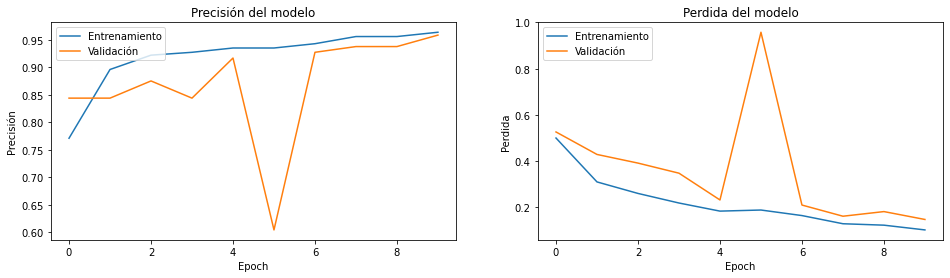

In [99]:
plot_history(grade_history)

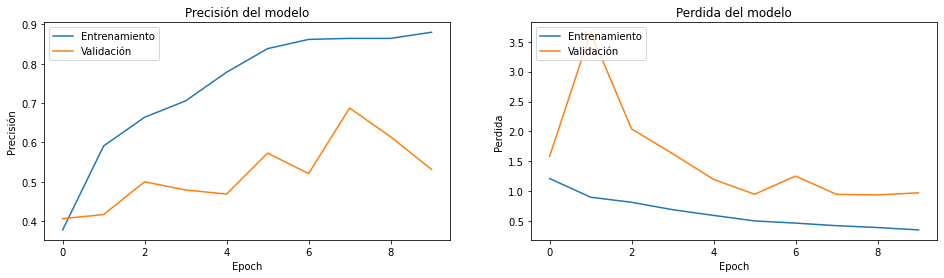

In [100]:
plot_history(survival_history)

In [101]:
grade_true = []
test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='grade', batch_size=test_batch_size )
grade_pred = grade_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)


index = dataframe.iloc[test_index]['grade']
for i in index:
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)

In [102]:

test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='survival', batch_size=test_batch_size )
survival_pred = survival_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)



survival_true = []
index = dataframe.iloc[test_index]['survival_days']
for i in index:
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)

In [103]:
plot_results(grade_true, grade_pred, grade_encoding)

              precision    recall  f1-score   support

         LGG       0.90      0.84      0.87        56
         HGG       0.88      0.93      0.90        68

    accuracy                           0.89       124
   macro avg       0.89      0.88      0.89       124
weighted avg       0.89      0.89      0.89       124



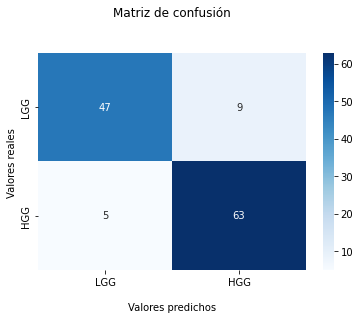

In [104]:
plot_confusion(grade_true, grade_pred, grade_encoding)

In [105]:
plot_results(survival_true, survival_pred, survival_encoding)

                precision    recall  f1-score   support

Short survivor       0.61      0.47      0.53        36
  Mid survivor       0.59      0.18      0.27        56
 Long survivor       0.41      1.00      0.58        32

      accuracy                           0.48       124
     macro avg       0.53      0.55      0.46       124
  weighted avg       0.55      0.48      0.43       124



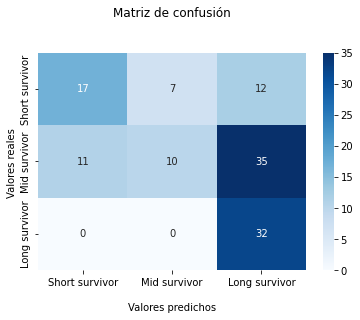

In [106]:
plot_confusion(survival_true, survival_pred, survival_encoding)

In [108]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
input_text = layers.Input(shape=(4,))

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_grado = crear_rama_grado(base, input_text)

rama_supervivencia = crear_rama_supervivencia(base, input_text)

# Model to be trained
grade_model = Model(inputs=[base_model.input, input_text], outputs=rama_grado, name="grade_model")
survival_model = Model(inputs=[base_model.input, input_text], outputs=rama_supervivencia, name="survival_model")
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = True

grade_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="binary_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

survival_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="categorical_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

In [109]:
batch_size = 16
valid_batch_size = 16

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, min_delta=0.01)
Reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    min_delta=0.01,
)

callbacks = [earylyStopping, Reducer]
train_gen = data_generator.generate_data(train_index, is_training=True, output='survival', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='survival', batch_size=valid_batch_size)

print("\n-----------------------------------------------SUPERVIVENCIA-----------------------------------------------")
survival_history = survival_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------SUPERVIVENCIA-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 38s 677ms/step - loss: 1.2079 - accuracy: 0.4089 - recall_23: 0.2344 - val_loss: 1.4351 - val_accuracy: 0.4271 - val_recall_23: 0.4271
Epoch 2/10
24/24 [==============================] - 10s 422ms/step - loss: 0.9792 - accuracy: 0.5729 - recall_23: 0.3854 - val_loss: 1.4296 - val_accuracy: 0.4896 - val_recall_23: 0.4688
Epoch 3/10
24/24 [==============================] - 10s 409ms/step - loss: 0.8017 - accuracy: 0.6745 - recall_23: 0.5547 - val_loss: 1.3935 - val_accuracy: 0.5521 - val_recall_23: 0.5208
Epoch 4/10
24/24 [==============================] - 10s 418ms/step - loss: 0.6557 - accuracy: 0.7318 - recall_23: 0.6484 - val_loss: 1.6547 - val_accuracy: 0.4583 - val_recall_23: 0.4479
Epoch 5/10
24/24 [==============================] - 10s 411ms/step - loss: 0.5769 - accuracy: 0.8125 - recall_23: 0.7240 - val_loss: 1.8538 - v

In [110]:
train_gen = data_generator.generate_data(train_index, is_training=True, output='grade', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='grade', batch_size=valid_batch_size)

print("\n-----------------------------------------------GRADO-----------------------------------------------")
grade_history = grade_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------GRADO-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 35s 591ms/step - loss: 0.4641 - accuracy: 0.8203 - recall_22: 0.8203 - val_loss: 0.7242 - val_accuracy: 0.4896 - val_recall_22: 0.4896
Epoch 2/10
24/24 [==============================] - 10s 424ms/step - loss: 0.2994 - accuracy: 0.9036 - recall_22: 0.9036 - val_loss: 0.7591 - val_accuracy: 0.5208 - val_recall_22: 0.5208
Epoch 3/10
24/24 [==============================] - 10s 427ms/step - loss: 0.2488 - accuracy: 0.9401 - recall_22: 0.9401 - val_loss: 0.5081 - val_accuracy: 0.7396 - val_recall_22: 0.7396
Epoch 4/10
24/24 [==============================] - 10s 437ms/step - loss: 0.1839 - accuracy: 0.9479 - recall_22: 0.9479 - val_loss: 0.4972 - val_accuracy: 0.8021 - val_recall_22: 0.8021
Epoch 5/10
24/24 [==============================] - 10s 418ms/step - loss: 0.1479 - accuracy: 0.9531 - recall_22: 0.9531 - val_loss: 0.2863 - val_accur

In [111]:
#grade_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-grade.h5")
#survival_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-survival.h5")

# 5. Evaluación

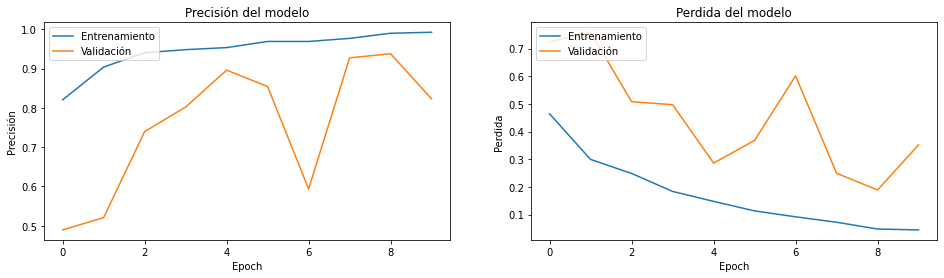

In [112]:
plot_history(grade_history)

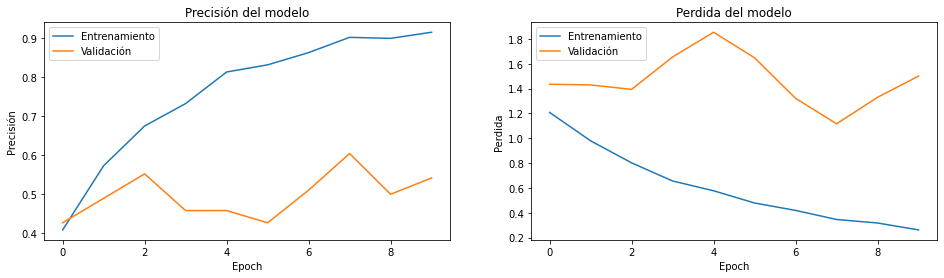

In [113]:
plot_history(survival_history)

In [114]:
grade_true = []
test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='grade', batch_size=test_batch_size )
grade_pred = grade_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)


index = dataframe.iloc[test_index]['grade']
for i in index:
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)

In [115]:

test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='survival', batch_size=test_batch_size )
survival_pred = survival_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)



survival_true = []
index = dataframe.iloc[test_index]['survival_days']
for i in index:
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)

In [116]:
plot_results(grade_true, grade_pred, grade_encoding)

              precision    recall  f1-score   support

         LGG       0.94      0.52      0.67        56
         HGG       0.71      0.97      0.82        68

    accuracy                           0.77       124
   macro avg       0.82      0.74      0.74       124
weighted avg       0.81      0.77      0.75       124



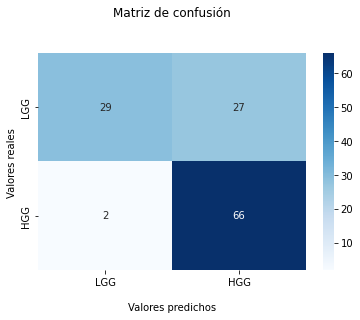

In [117]:
plot_confusion(grade_true, grade_pred, grade_encoding)

In [118]:
plot_results(survival_true, survival_pred, survival_encoding)

                precision    recall  f1-score   support

Short survivor       0.39      0.42      0.41        36
  Mid survivor       0.50      0.41      0.45        56
 Long survivor       0.57      0.72      0.64        32

      accuracy                           0.49       124
     macro avg       0.49      0.52      0.50       124
  weighted avg       0.49      0.49      0.49       124



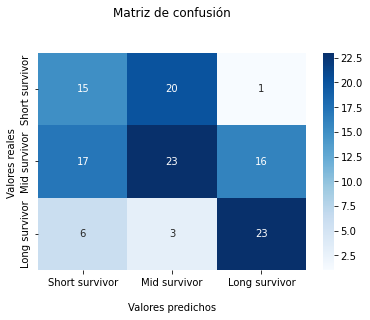

In [119]:
plot_confusion(survival_true, survival_pred, survival_encoding)

In [120]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
input_text = layers.Input(shape=(4,))

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_grado = crear_rama_grado(base, input_text)

rama_supervivencia = crear_rama_supervivencia(base, input_text)

# Model to be trained
grade_model = Model(inputs=[base_model.input, input_text], outputs=rama_grado, name="grade_model")
survival_model = Model(inputs=[base_model.input, input_text], outputs=rama_supervivencia, name="survival_model")
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = True

grade_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="binary_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

survival_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="categorical_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

In [121]:
batch_size = 16
valid_batch_size = 16

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, min_delta=0.01)
Reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    min_delta=0.01,
)

callbacks = [earylyStopping, Reducer]
train_gen = data_generator.generate_data(train_index, is_training=True, output='survival', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='survival', batch_size=valid_batch_size)

print("\n-----------------------------------------------SUPERVIVENCIA-----------------------------------------------")
survival_history = survival_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------SUPERVIVENCIA-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 21s 359ms/step - loss: 1.2234 - accuracy: 0.3594 - recall_25: 0.2188 - val_loss: 3.5557 - val_accuracy: 0.4167 - val_recall_25: 0.4167
Epoch 2/10
24/24 [==============================] - 6s 256ms/step - loss: 0.9138 - accuracy: 0.5573 - recall_25: 0.3776 - val_loss: 4.2599 - val_accuracy: 0.4167 - val_recall_25: 0.4167
Epoch 3/10
24/24 [==============================] - 6s 251ms/step - loss: 0.7821 - accuracy: 0.6979 - recall_25: 0.5443 - val_loss: 2.5662 - val_accuracy: 0.4688 - val_recall_25: 0.4583
Epoch 4/10
24/24 [==============================] - 6s 251ms/step - loss: 0.6583 - accuracy: 0.7448 - recall_25: 0.6354 - val_loss: 2.0476 - val_accuracy: 0.4479 - val_recall_25: 0.4167
Epoch 5/10
24/24 [==============================] - 6s 252ms/step - loss: 0.5973 - accuracy: 0.7943 - recall_25: 0.7083 - val_loss: 1.3197 - val_a

In [122]:
train_gen = data_generator.generate_data(train_index, is_training=True, output='grade', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='grade', batch_size=valid_batch_size)

print("\n-----------------------------------------------GRADO-----------------------------------------------")
grade_history = grade_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------GRADO-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 24s 354ms/step - loss: 0.4940 - accuracy: 0.7474 - recall_24: 0.7474 - val_loss: 0.6271 - val_accuracy: 0.7188 - val_recall_24: 0.7188
Epoch 2/10
24/24 [==============================] - 6s 252ms/step - loss: 0.3110 - accuracy: 0.8724 - recall_24: 0.8724 - val_loss: 0.6586 - val_accuracy: 0.6146 - val_recall_24: 0.6146
Epoch 3/10
24/24 [==============================] - 6s 248ms/step - loss: 0.2640 - accuracy: 0.9219 - recall_24: 0.9219 - val_loss: 0.4479 - val_accuracy: 0.8229 - val_recall_24: 0.8229
Epoch 4/10
24/24 [==============================] - 6s 249ms/step - loss: 0.2054 - accuracy: 0.9323 - recall_24: 0.9323 - val_loss: 0.5089 - val_accuracy: 0.7500 - val_recall_24: 0.7500
Epoch 5/10
24/24 [==============================] - 6s 250ms/step - loss: 0.1960 - accuracy: 0.9323 - recall_24: 0.9323 - val_loss: 0.2963 - val_accuracy:

In [123]:
#grade_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-grade.h5")
#survival_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-survival.h5")

# 5. Evaluación

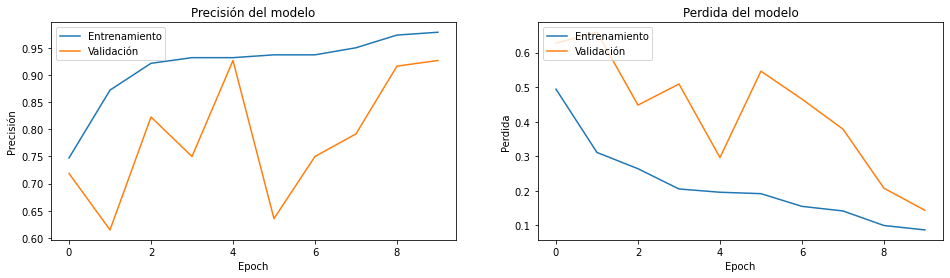

In [124]:
plot_history(grade_history)

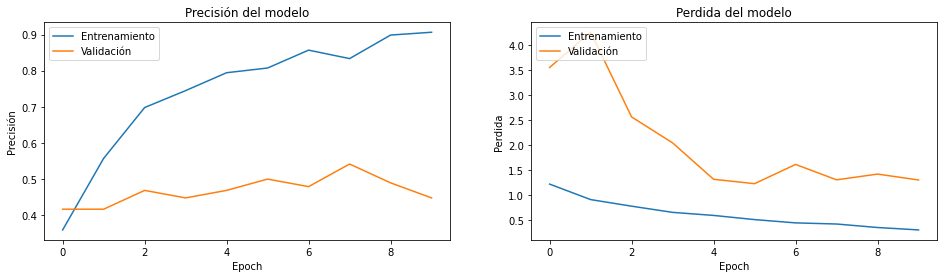

In [125]:
plot_history(survival_history)

In [126]:
grade_true = []
test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='grade', batch_size=test_batch_size )
grade_pred = grade_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)


index = dataframe.iloc[test_index]['grade']
for i in index:
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)

In [127]:

test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='survival', batch_size=test_batch_size )
survival_pred = survival_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)



survival_true = []
index = dataframe.iloc[test_index]['survival_days']
for i in index:
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)

In [128]:
plot_results(grade_true, grade_pred, grade_encoding)

              precision    recall  f1-score   support

         LGG       0.98      0.93      0.95        56
         HGG       0.94      0.99      0.96        68

    accuracy                           0.96       124
   macro avg       0.96      0.96      0.96       124
weighted avg       0.96      0.96      0.96       124



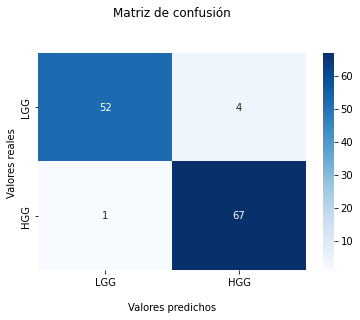

In [129]:
plot_confusion(grade_true, grade_pred, grade_encoding)

In [130]:
plot_results(survival_true, survival_pred, survival_encoding)

                precision    recall  f1-score   support

Short survivor       0.43      0.17      0.24        36
  Mid survivor       0.51      0.36      0.42        56
 Long survivor       0.45      1.00      0.62        32

      accuracy                           0.47       124
     macro avg       0.46      0.51      0.43       124
  weighted avg       0.47      0.47      0.42       124



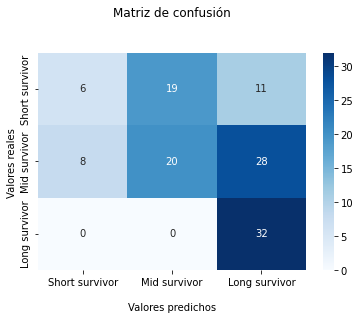

In [131]:
plot_confusion(survival_true, survival_pred, survival_encoding)

In [132]:
from tensorflow.keras.applications.efficientnet import EfficientNetB4
input_text = layers.Input(shape=(4,))

base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_grado = crear_rama_grado(base, input_text)

rama_supervivencia = crear_rama_supervivencia(base, input_text)

# Model to be trained
grade_model = Model(inputs=[base_model.input, input_text], outputs=rama_grado, name="grade_model")
survival_model = Model(inputs=[base_model.input, input_text], outputs=rama_supervivencia, name="survival_model")
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = True

grade_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="binary_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

survival_model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss="categorical_crossentropy",
            metrics = ['accuracy', tf.keras.metrics.Recall()]
)

In [133]:
batch_size = 16
valid_batch_size = 16

earylyStopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, min_delta=0.01)
Reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    min_delta=0.01,
)

callbacks = [earylyStopping, Reducer]
train_gen = data_generator.generate_data(train_index, is_training=True, output='survival', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='survival', batch_size=valid_batch_size)

print("\n-----------------------------------------------SUPERVIVENCIA-----------------------------------------------")
survival_history = survival_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------SUPERVIVENCIA-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 40s 741ms/step - loss: 1.1525 - accuracy: 0.4609 - recall_27: 0.2344 - val_loss: 4.2217 - val_accuracy: 0.4583 - val_recall_27: 0.4583
Epoch 2/10
24/24 [==============================] - 14s 584ms/step - loss: 0.9398 - accuracy: 0.5599 - recall_27: 0.3750 - val_loss: 2.4692 - val_accuracy: 0.5417 - val_recall_27: 0.5000
Epoch 3/10
24/24 [==============================] - 14s 572ms/step - loss: 0.8243 - accuracy: 0.6276 - recall_27: 0.4688 - val_loss: 2.0361 - val_accuracy: 0.2083 - val_recall_27: 0.1667
Epoch 4/10
24/24 [==============================] - 14s 570ms/step - loss: 0.7563 - accuracy: 0.6797 - recall_27: 0.5521 - val_loss: 1.5167 - val_accuracy: 0.4167 - val_recall_27: 0.2500
Epoch 5/10
24/24 [==============================] - 13s 552ms/step - loss: 0.7252 - accuracy: 0.6849 - recall_27: 0.5651 - val_loss: 1.5086 - v

In [134]:
train_gen = data_generator.generate_data(train_index, is_training=True, output='grade', batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, output='grade', batch_size=valid_batch_size)

print("\n-----------------------------------------------GRADO-----------------------------------------------")
grade_history = grade_model.fit(train_gen,
                    steps_per_epoch=(len(train_index)*4)//batch_size,
                    epochs=epochs,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index)*4)//valid_batch_size,
                    verbose=1)


-----------------------------------------------GRADO-----------------------------------------------
Epoch 1/10
24/24 [==============================] - 39s 726ms/step - loss: 0.5149 - accuracy: 0.7500 - recall_26: 0.7500 - val_loss: 0.7294 - val_accuracy: 0.5000 - val_recall_26: 0.5000
Epoch 2/10
24/24 [==============================] - 14s 567ms/step - loss: 0.3363 - accuracy: 0.8854 - recall_26: 0.8854 - val_loss: 0.6968 - val_accuracy: 0.5000 - val_recall_26: 0.5000
Epoch 3/10
24/24 [==============================] - 14s 575ms/step - loss: 0.2342 - accuracy: 0.9349 - recall_26: 0.9349 - val_loss: 0.7019 - val_accuracy: 0.4583 - val_recall_26: 0.4583
Epoch 4/10
24/24 [==============================] - 14s 577ms/step - loss: 0.1970 - accuracy: 0.9349 - recall_26: 0.9349 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall_26: 0.5000
Epoch 5/10
24/24 [==============================] - 13s 560ms/step - loss: 0.2168 - accuracy: 0.9297 - recall_26: 0.9297 - val_loss: 0.6919 - val_accur

In [135]:
#grade_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-grade.h5")
#survival_model.save("C:/Users/Usuario/Desktop/tfg/modelos/TO1TAL-survival.h5")

# 5. Evaluación

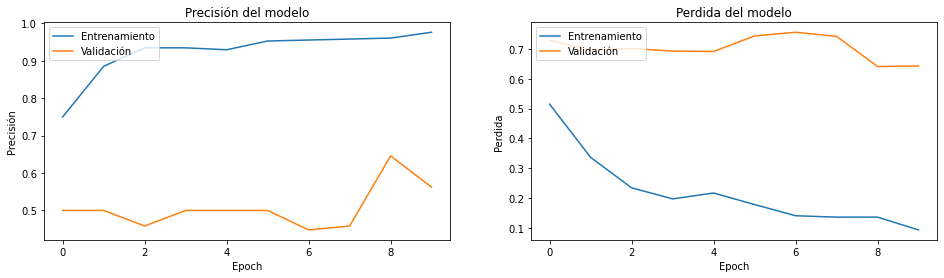

In [136]:
plot_history(grade_history)

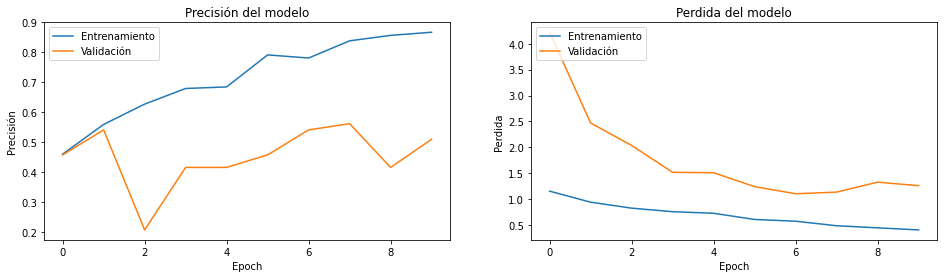

In [137]:
plot_history(survival_history)

In [138]:
grade_true = []
test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='grade', batch_size=test_batch_size )
grade_pred = grade_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)


index = dataframe.iloc[test_index]['grade']
for i in index:
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)
    grade_true.append(i)

In [139]:

test_batch_size = len(test_index)
test_generator = data_generator.generate_data(test_index, is_training=False, output='survival', batch_size=test_batch_size )
survival_pred = survival_model.predict(test_generator, steps=(len(test_index)*4)//test_batch_size)



survival_true = []
index = dataframe.iloc[test_index]['survival_days']
for i in index:
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)
    survival_true.append(i)

In [140]:
plot_results(grade_true, grade_pred, grade_encoding)

              precision    recall  f1-score   support

         LGG       0.60      0.55      0.57        56
         HGG       0.65      0.69      0.67        68

    accuracy                           0.63       124
   macro avg       0.62      0.62      0.62       124
weighted avg       0.63      0.63      0.63       124



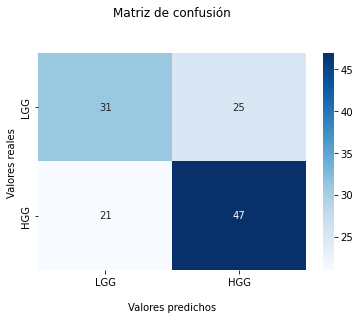

In [141]:
plot_confusion(grade_true, grade_pred, grade_encoding)

In [142]:
plot_results(survival_true, survival_pred, survival_encoding)

                precision    recall  f1-score   support

Short survivor       0.59      0.56      0.57        36
  Mid survivor       1.00      0.04      0.07        56
 Long survivor       0.36      1.00      0.53        32

      accuracy                           0.44       124
     macro avg       0.65      0.53      0.39       124
  weighted avg       0.72      0.44      0.33       124



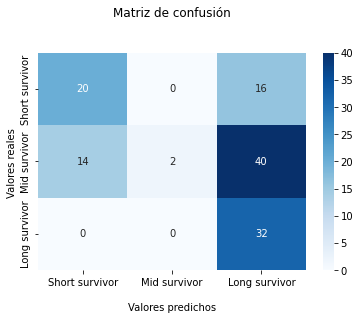

In [143]:
plot_confusion(survival_true, survival_pred, survival_encoding)